In [2]:
import numpy as np
import matplotlib.pyplot as plt

from astroML.utils import pickle_results
from astroML.datasets import fetch_sdss_specgals
from astroML.correlation import bootstrap_two_point_angular

from astroML.plotting import setup_text_plots
setup_text_plots(fontsize=8, usetex=True)

In [3]:
#Se obtienen datos de la librería
data = fetch_sdss_specgals()

In [3]:
#Cortes de datos
Mmax = 17.7
Zmin,Zmax=0.08,0.12 
RAmin,RAmax=140,220
DECmin,DECmax=5,45
#redshift
data=data[data['z'] < Zmax]
data=data[data['z'] > Zmin]
data=data[data['petroMag_r'] < Mmax]
#right ascension
data=data[data['ra'] < RAmax]
data=data[data['ra'] > RAmin]
#declinación
data=data[data['dec'] < DECmax]
data=data[data['dec'] > DECmin]

In [4]:
ur = data['modelMag_u'] - data['modelMag_r']

#divide entre galaxias rojas y azules
flag_red = (ur > 2.22)
flag_blue = ~flag_red
data_red = data[flag_red]
data_blue = data[flag_blue]

#Imprime tamaños de arreglo de datos y tamaño de las divisiones de azules y rojas
print("data size:", len(data))
print("red gals:", len(data_red))
print("blue gals:", len(data_blue))

data size: 54900
red gals: 38017
blue gals: 16883


In [5]:
#Creamos una función para el cálculo de la correlación
@pickle_results("correlation_functions.pkl")
def compute_results(Nbins=16, Nbootstraps=1,  method='landy-szalay', rseed=0):
    np.random.seed(rseed)
    bins = 10 ** np.linspace(np.log10(1. / 60.), np.log10(6), 16)

    results = [bins]
    for D in [data_red, data_blue]:
        results += bootstrap_two_point_angular(D['ra'],D['dec'],bins=bins,method=method,Nbootstraps=Nbootstraps)

    return results

In [6]:
#Se guardan los datos en arreglos
(bins, r_corr, r_corr_err, r_bootstraps,
 b_corr, b_corr_err, b_bootstraps) = compute_results()
#Se calcula el centro de los bins
bin_centers = 0.5 * (bins[1:] + bins[:-1])

@pickle_results: using precomputed results from 'correlation_functions.pkl'


In [7]:
#Se grafican los resultados
corr = [r_corr, b_corr]
#no regresa valores de error de correlación
corr_err = [r_corr_err, b_corr_err]
bootstraps = [r_bootstraps, b_bootstraps]
labels = ['$u-r > 2.22$\n$N=%i$' % len(data_red),
          '$u-r < 2.22$\n$N=%i$' % len(data_blue)]

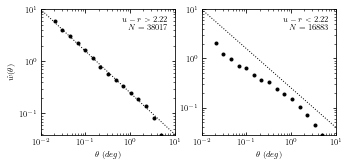

In [10]:
fig = plt.figure(figsize=(5, 2.5))
fig.subplots_adjust(bottom=0.2, top=0.9,
                    left=0.13, right=0.95)
for i in range(2):
    ax = fig.add_subplot(121 + i, xscale='log', yscale='log')

    ax.errorbar(bin_centers, corr[i], corr_err[i],
                fmt='.k', ecolor='red', lw=5)

    t = np.array([0.01, 10])
    ax.plot(t, 10 * (t / 0.01) ** -0.8, ':k', linewidth=1)

    ax.text(0.95, 0.95, labels[i],
            ha='right', va='top', transform=ax.transAxes)
    ax.set_xlabel(r'$\theta\ (deg)$')
    if i == 0:
        ax.set_ylabel(r'$\hat{w}(\theta)$')

plt.savefig("figura.png")
plt.show()
